# Turing Target Practice

## Model

In [1]:
] activate "."

  Activating project at `~/Glamdring/MicroCanonicalHMC.jl`


In [2]:
# The statistical inference frame-work we will use
using Turing
using Interpolations
using ForwardDiff
using LinearAlgebra
#using StatsPlots
using PyPlot
using Distributed

using Revise
using MicroCanonicalHMC

[ Info: Precompiling MicroCanonicalHMC [234d2aa0-2291-45f7-9047-6fa6f316b0a8]


In [3]:
fs8_zs = [0.38, 0.51, 0.61, 1.48, 0.44, 0.6, 0.73, 0.6, 0.86, 0.067, 1.4]
fs8_data = [0.49749, 0.457523, 0.436148, 0.462, 0.413, 0.39, 0.437, 0.55, 0.4, 0.423, 0.482]
fs8_cov = [0.00203355 0.000811829 0.000264615 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0;
           0.000811829 0.00142289 0.000662824 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 
           0.000264615 0.000662824 0.00118576 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0;
           0.0 0.0 0.0 0.002025 0.0 0.0 0.0 0.0 0.0 0.0 0.0;
           0.0 0.0 0.0 0.0 0.0064 0.00257 0.0 0.0 0.0 0.0 0.0;
           0.0 0.0 0.0 0.0 0.00257 0.003969 0.00254 0.0 0.0 0.0 0.0;
           0.0 0.0 0.0 0.0 0.0 0.00254 0.005184 0.0 0.0 0.0 0.0;
           0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0144 0.0 0.0 0.0;
           0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0121 0.0 0.0; 
           0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.003025 0.0;
           0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.013456000000000001];

In [4]:
function make_fs8(Ωm, σ8; Ωr=8.24*10^-5)
    # ODE solution for growth factor
    x_Dz = LinRange(0, log(1+1100), 300)
    dx_Dz = x_Dz[2]-x_Dz[1]
    z_Dz = @.(exp(x_Dz) - 1)
    a_Dz = @.(1/(1+z_Dz))
    aa = reverse(a_Dz)
    e =  @.(sqrt.(abs(Ωm)*(1+z_Dz)^3+Ωr*(1+z_Dz)^4+(1-Ωm-Ωr)))
    ee = reverse(e)

    dd = zeros(typeof(Ωm), 300)
    yy = zeros(typeof(Ωm), 300)
    dd[1] = aa[1]
    yy[1] = aa[1]^3*ee[end]

    for i in 1:(300-1)
        A0 = -1.5 * Ωm / (aa[i]*ee[i])
        B0 = -1. / (aa[i]^2*ee[i])
        A1 = -1.5 * Ωm / (aa[i+1]*ee[i+1])
        B1 = -1. / (aa[i+1]^2*ee[i+1])
        yy[i+1] = (1+0.5*dx_Dz^2*A0*B0)*yy[i] + 0.5*(A0+A1)*dx_Dz*dd[i]
        dd[i+1] = 0.5*(B0+B1)*dx_Dz*yy[i] + (1+0.5*dx_Dz^2*A0*B0)*dd[i]
    end

    y = reverse(yy)
    d = reverse(dd)

    Dzi = LinearInterpolation(z_Dz, d./d[1], extrapolation_bc=Line())
    fs8zi = LinearInterpolation(z_Dz, -σ8 .* y./ (a_Dz.^2 .*e.*d[1]),
                                 extrapolation_bc=Line())
    return fs8zi
end

make_fs8 (generic function with 1 method)

In [5]:
@model function model(data; cov = fs8_cov) 
    # Define priors
    #KiDS priors
    Ωm  ~ Uniform(0.01, 0.6)
    σ8 ~ Normal(0.8, 0.3)
    fs8_itp = make_fs8(Ωm, σ8)
    theory = fs8_itp(fs8_zs)
    data ~ MvNormal(theory, cov)
end;

In [6]:
stat_model = model(fs8_data)

DynamicPPL.Model{typeof(model), (:data, :cov), (:cov,), (), Tuple{Vector{Float64}, Matrix{Float64}}, Tuple{Matrix{Float64}}, DynamicPPL.DefaultContext}(model, (data = [0.49749, 0.457523, 0.436148, 0.462, 0.413, 0.39, 0.437, 0.55, 0.4, 0.423, 0.482], cov = [0.00203355 0.000811829 … 0.0 0.0; 0.000811829 0.00142289 … 0.0 0.0; … ; 0.0 0.0 … 0.003025 0.0; 0.0 0.0 … 0.0 0.013456000000000001]), (cov = [0.00203355 0.000811829 … 0.0 0.0; 0.000811829 0.00142289 … 0.0 0.0; … ; 0.0 0.0 … 0.003025 0.0; 0.0 0.0 … 0.0 0.013456000000000001],), DynamicPPL.DefaultContext())

## Sampling

In [7]:
target = TuringTarget(stat_model);

In [8]:
spl = MCHMC(0.0, 0.0; init_eps=0.1, varE_wanted=0.01, sigma=ones(2))
samples_mchmc = Sample(spl, target, 100_000;
                       burn_in=10_000,  
                       file_name="Turing_sequential_samples.txt",
                       dialog=true);

[ Info: Using given sigma ✅
[ Info: Tuning eps ⏳
[ Info: Tuning L ⏳
[ Info: Starting burn in ⏳


Using eps tuning method AdaptiveStep
eps: 0.1

[ Info: Burn in finished


 --> VarE/d: 39.38430088658583
eps: 0.033128302782282085 --> VarE/d: 18.409335542229744
eps: 0.01779130090654384 --> VarE/d: 2.5922088124037805
eps: 0.012008610736279367 --> VarE/d: 0.6751461976931661
eps: 0.009415728816274699 --> VarE/d: 0.2295172863696784
eps: 0.008105050345153783 --> VarE/d: 0.10301177319472833
eps: 0.007380338302122905 --> VarE/d: 0.04171403144006039
eps: 0.007023494960810882 --> VarE/d: 0.014558254751182218
eps: 0.006943938496901559 --> VarE/d: 0.0021087330137247893
eps: 0.00722894621879846 --> VarE/d: 0.00046123435001108005
eps: 0.007717975814034633 --> VarE/d: 0.009680874070339263


[ Info: Found eps: 0.007717975814034633 ✅


samples: 100--> 1/<1/ess>: 0.037346536016164146
samples: 203--> 1/<1/ess>: 0.0116421500164718
samples: 310--> 1/<1/ess>: 0.00905001893564863
samples: 420--> 1/<1/ess>: 0.018824621418480774
samples: 534--> 1/<1/ess>: 0.005953984289869452
samples: 652--> 1/<1/ess>: 0.004803751377303004
samples: 774--> 1/<1/ess>: 0.005154619198698365
samples: 900--> 1/<1/ess>: 0.006030809057426529
samples: 1030--> 1/<1/ess>: 0.008036435253370323
samples: 1164--> 1/<1/ess>: 0.011026984711734394


[ Info: Found L: 0.2799668636820193 ✅


In [9]:
Wms_mchmc = [sample[1] for sample in samples_mchmc]
s8s_mchmc = [sample[2] for sample in samples_mchmc];

In [32]:
samples = samples_mchmc
#_samples = zeros(length(samples), length(samples[1]), 1)
#_samples[:, :, 1] = mapreduce(permutedims, vcat, samples)
#_samples = permutedims(_samples, (1,3,2))
#ess, rhat = MCMCDiagnosticTools.ess_rhat(_samples)

100001-element Vector{Any}:
 [0.2579454771150068, 0.7908245598973201, 0.0, 15.192647967458146]
 [0.223456401545705, 0.8785574740386757, -0.1362375630948094, 16.262557544100307]
 [0.22346548139914055, 0.8862751620602033, -0.26306776097133877, 16.174839934223893]
 [0.22327579215076343, 0.8938664492690541, -0.37158705892904464, 16.050598186796197]
 [0.22313412868805677, 0.9015139771934131, -0.4953866903470008, 15.885049924767786]
 [0.22276998178058727, 0.908753269654644, -0.5582977955922903, 15.697086503203654]
 [0.22235518637905263, 0.9158428619045403, -0.6365994965605317, 15.48187967875859]
 [0.2216228864230105, 0.921365271925488, -0.5108580376650185, 15.304936548588115]
 [0.22065994563032537, 0.9243858486765032, -0.24124836974333164, 15.219391041598632]
 [0.2196221420633262, 0.923532838983907, 0.18510486119675917, 15.285312434637227]
 [0.2187684022242568, 0.9191071520471575, 0.5356388315576339, 15.470464045420126]
 [0.21826273876216437, 0.9123617610267627, 0.6766830838558704, 15.697942

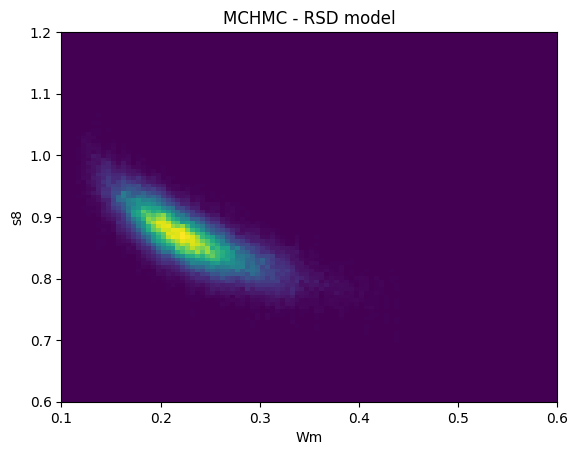

In [11]:
plt.hist2d(Wms_mchmc, s8s_mchmc, bins=100, range=[[0.1, 0.6],[0.6, 1.2]]);
plt.xlabel("Wm")
plt.ylabel("s8")
plt.title("MCHMC - RSD model");

In [53]:
spl = MCHMC(0.007, 0.27, 10; init_eps=0.05, varE_wanted=1.0, sigma=ones(2))
samples_ensemble_mchmc = Sample(spl, target, 10000;
                                burn_in=1000,
                                monitor_energy=true, 
                                dialog=true)

Initial Virial loss: 13163.427817360976
Virial loss: 111.85369873139915 --> Relative improvement: 0.02508702232837834
Virial loss: 109.07968299295791 --> Relative improvement: 0.024800393459519343
Virial loss: 106.38312235398033 --> Relative improvement: 0.024721016462356915
Virial loss: 103.79288536010169 --> Relative improvement: 0.024348194869293738
Virial loss: 101.30800759842134 --> Relative improvement: 0.02394073305756217
Virial loss: 98.90164042782261 --> Relative improvement: 0.02375298091082212
Virial loss: 96.58559549903227 --> Relative improvement: 0.02341765939140894
Virial loss: 94.34294844523576 --> Relative improvement: 0.02321927034988336
Virial loss: 92.2088374916007 --> Relative improvement: 0.022620778646470496
Virial loss: 90.15362590341482 --> Relative improvement: 0.022288661738882554
Virial loss: 88.1325047181371 --> Relative improvement: 0.022418634470043663
Virial loss: 86.1069112768595 --> Relative improvement: 0.02298350021658624
Virial loss: 84.098262017859

[ Info: Using given sigma ✅
[ Info: Using given eps ✅
[ Info: Using given L ✅
[ Info: Starting burn in ⏳


Virial loss: 30.90153069734281 --> Relative improvement: 0.04044183295719772
Virial loss: 29.711322924864533 --> Relative improvement: 0.03851614291005401
Virial loss: 28.817222437416678 --> Relative improvement: 0.03009292079349346
Virial loss: 28.13063621432801 --> Relative improvement: 0.023825551701929237
Virial loss: 27.548580817990445 --> Relative improvement: 0.020691156499372143
Virial loss: 26.763356190019266 --> Relative improvement: 0.028503269666014575
Virial loss: 25.78216008061613 --> Relative improvement: 0.036661923207114366
Virial loss: 24.806685725945893 --> Relative improvement: 0.03783524544181349
Virial loss: 23.915472373510735 --> Relative improvement: 0.035926337048040935
Virial loss: 23.21420393772295 --> Relative improvement: 0.029322792576931267
Virial loss: 22.761778549201345 --> Relative improvement: 0.019489162313527153
Virial loss: 22.340724639445376 --> Relative improvement: 0.01849828689115085
Virial loss: 21.82829813059505 --> Relative improvement: 0.02

[ Info: Virial loss condition met during burn-in at step: 55


100000-element Vector{Any}:
 [0.1722558160662152, 0.8820544316609694, 0.16416717534759329, 15.538563443623763]
 [0.17296389587077762, 0.8856412281055723, 0.2894263136102939, 15.636467793691017]
 [0.1735266282351471, 0.890768332976685, 0.3073307697616645, 15.73959802782131]
 [0.17393733681524448, 0.896846636400146, 0.2615420188043327, 15.82694387632014]
 [0.17442262390369945, 0.9025235238306322, 0.17847986315832287, 15.88658285495025]
 [0.17480708152651694, 0.9087289267977426, 0.10208321761707673, 15.92059450810461]
 [0.1751683354814079, 0.9150345619339688, 0.01626371273455618, 15.925937155511097]
 [0.17564527815409933, 0.9207744200636371, -0.055018111132094205, 15.90737531027327]
 [0.17625328053840703, 0.9255717761881868, -0.09916654237212441, 15.873818905833415]
 [0.176953400715407, 0.9294069276272536, -0.11827419459677202, 15.833598872162382]
 [0.17772506673256913, 0.9321570841897306, -0.10956791159807189, 15.796098682271987]
 [0.17851441050218872, 0.9345831212958581, -0.118526135735

In [54]:
Wms_ensemble_mchmc = [sample[1] for sample in samples_ensemble_mchmc]
s8s_ensemble_mchmc = [sample[2] for sample in samples_ensemble_mchmc];

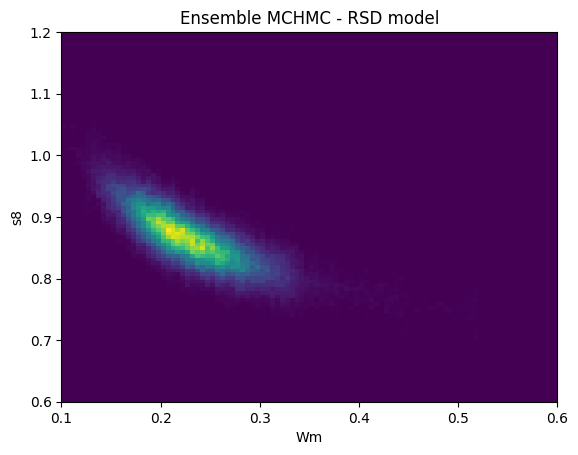

In [55]:
plt.hist2d(Wms_ensemble_mchmc, s8s_ensemble_mchmc, bins=100, range=[[0.1, 0.6],[0.6, 1.2]]);
plt.xlabel("Wm")
plt.ylabel("s8")
plt.title("Ensemble MCHMC - RSD model");

##  AbstractMCMC

In [14]:
samples = sample(
    stat_model, MCHMC(varE_wanted=2.0), 10000;
    dialog=true)

[ Info: Tuning sigma ⏳
[ Info: Tuning eps ⏳
[ Info: Tuning L ⏳


LoadError: DomainError with -0.33934227649544785:
sqrt will only return a complex result if called with a complex argument. Try sqrt(Complex(x)).

In [15]:
new_samples = sample(stat_model, MCHMC(varE_wanted=2.0), 10000; 
                     monitor_energy=true, 
                     progress=true, resume_from=samples)

LoadError: UndefVarError: `samples` not defined

## Ensemble AbstractMCMC

In [16]:
samples = sample(stat_model, MCHMC(100), 1000, 100)

[ Info: Burn-in started ⏳
[ Info: Tuning sigma ⏳
[ Info: Tuning eps ⏳
[ Info: Tuning L ⏳
┌ Warning: L-tuning not Implemented
└ @ MicroCanonicalHMC ~/PhD/MicroCanonicalHMC.jl/src/ensemble/tuning.jl:41
[ Info: Found L: 1.4142135623730951 ✅
[ Info: VarE condition met during eps tuning at step: 13
[ Info: Found eps: 0.008664620420202015 ✅
[ Info: Virial loss condition met during burn-in at step: 2
[ Info: Found sigma: [1.620616898256196, 0.2532292543539198] ✅
┌ Warning: Maximum number of steps reached during eps tuning
└ @ MicroCanonicalHMC ~/PhD/MicroCanonicalHMC.jl/src/ensemble/tuning.jl:214
[ Info: Found eps: 0.0043824511407622386 ✅
Chain 1: 100%|██████████████████████████████████████████| Time: 0:00:04


Chains MCMC chain (100000×4×1 Array{Float64, 3}):

Iterations        = 1:1:100000
Number of chains  = 1
Samples per chain = 100000
Wall duration     = 6.0 seconds
Compute duration  = 6.0 seconds
parameters        = Ωm, σ8
internals         = E, logp

Summary Statistics
  parameters      mean       std   naive_se      mcse        ess      rhat   e ⋯
      Symbol   Float64   Float64    Float64   Float64    Float64   Float64     ⋯

          Ωm    0.2901    0.1673     0.0005    0.0088   233.6325    1.0001     ⋯
          σ8    0.7617    0.2533     0.0008    0.0133   232.2530    1.0074     ⋯
                                                                1 column omitted

Quantiles
  parameters      2.5%     25.0%     50.0%     75.0%     97.5% 
      Symbol   Float64   Float64   Float64   Float64   Float64 

          Ωm    0.0259    0.1396    0.2759    0.4387    0.5603
          σ8    0.3356    0.5914    0.7780    0.9295    1.2868


In [17]:
new_samples = sample(stat_model, MCHMC(100), 1000, 100; 
                     resume_from=samples)

[ Info: Starting from previous run
Chain 1: 100%|██████████████████████████████████████████| Time: 0:00:03


Chains MCMC chain (100000×4×1 Array{Float64, 3}):

Iterations        = 1:1:100000
Number of chains  = 1
Samples per chain = 100000
Wall duration     = 3.38 seconds
Compute duration  = 3.38 seconds
parameters        = Ωm, σ8
internals         = E, logp

Summary Statistics
  parameters      mean       std   naive_se      mcse        ess      rhat   e ⋯
      Symbol   Float64   Float64    Float64   Float64    Float64   Float64     ⋯

          Ωm    0.2404    0.0736     0.0002    0.0040   224.4534    1.0585     ⋯
          σ8    0.8627    0.0653     0.0002    0.0035   226.0813    1.0283     ⋯
                                                                1 column omitted

Quantiles
  parameters      2.5%     25.0%     50.0%     75.0%     97.5% 
      Symbol   Float64   Float64   Float64   Float64   Float64 

          Ωm    0.1345    0.1857    0.2350    0.2774    0.4314
          σ8    0.7524    0.8142    0.8569    0.9029    0.9855


## Parallelization

In [18]:
samples = sample(
    stat_model, MCHMC(varE_wanted=2.0), MCMCThreads(), 30000, 4;
    monitor_energy=true, 
    dialog=true)

[ Info: number of chains: 4 smaller than number of threads: 10. Increase the number of chains to make full use of your threads.
[ Info: Tuning sigma ⏳
[ Info: Tuning sigma ⏳
[ Info: Tuning sigma ⏳
[ Info: Tuning sigma ⏳
[ Info: Tuning eps ⏳
[ Info: Tuning eps ⏳
[ Info: Tuning eps ⏳
[ Info: Tuning L ⏳
[ Info: Tuning L ⏳
[ Info: Tuning L ⏳
[ Info: Tuning eps ⏳
[ Info: Tuning L ⏳


LoadError: TaskFailedException

[91m    nested task error: [39mDomainError with -0.33934227649544785:
    sqrt will only return a complex result if called with a complex argument. Try sqrt(Complex(x)).
    Stacktrace:
      [1] [0m[1mthrow_complex_domainerror[22m[0m[1m([22m[90mf[39m::[0mSymbol, [90mx[39m::[0mFloat64[0m[1m)[22m
    [90m    @[39m [90mBase.Math[39m [90m./[39m[90m[4mmath.jl:33[24m[39m
      [2] [0m[1msqrt[22m
    [90m    @[39m [90m./[39m[90m[4mmath.jl:677[24m[39m[90m [inlined][39m
      [3] [0m[1m_broadcast_getindex_evalf[22m
    [90m    @[39m [90m./[39m[90m[4mbroadcast.jl:683[24m[39m[90m [inlined][39m
      [4] [0m[1m_broadcast_getindex[22m
    [90m    @[39m [90m./[39m[90m[4mbroadcast.jl:656[24m[39m[90m [inlined][39m
      [5] [0m[1mgetindex[22m
    [90m    @[39m [90m./[39m[90m[4mbroadcast.jl:610[24m[39m[90m [inlined][39m
      [6] [0m[1mmacro expansion[22m
    [90m    @[39m [90m./[39m[90m[4mbroadcast.jl:974[24m[39m[90m [inlined][39m
      [7] [0m[1mmacro expansion[22m
    [90m    @[39m [90m./[39m[90m[4msimdloop.jl:77[24m[39m[90m [inlined][39m
      [8] [0m[1mcopyto![22m
    [90m    @[39m [90m./[39m[90m[4mbroadcast.jl:973[24m[39m[90m [inlined][39m
      [9] [0m[1mcopyto![22m
    [90m    @[39m [90m./[39m[90m[4mbroadcast.jl:926[24m[39m[90m [inlined][39m
     [10] [0m[1mcopy[22m
    [90m    @[39m [90m./[39m[90m[4mbroadcast.jl:898[24m[39m[90m [inlined][39m
     [11] [0m[1mmaterialize[22m[0m[1m([22m[90mbc[39m::[0mBase.Broadcast.Broadcasted[90m{Base.Broadcast.DefaultArrayStyle{1}, Nothing, typeof(sqrt), Tuple{Vector{Float64}}}[39m[0m[1m)[22m
    [90m    @[39m [90mBase.Broadcast[39m [90m./[39m[90m[4mbroadcast.jl:873[24m[39m
     [12] [0m[1mtune_sigma![22m[0m[1m([22m[90msampler[39m::[0mMicroCanonicalHMC.Sampler, [90mtarget[39m::[0mTuringTarget; [90mkwargs[39m::[0mBase.Pairs[90m{Symbol, Bool, Tuple{Symbol, Symbol}, NamedTuple{(:monitor_energy, :dialog), Tuple{Bool, Bool}}}[39m[0m[1m)[22m
    [90m    @[39m [35mMicroCanonicalHMC[39m [90m~/PhD/MicroCanonicalHMC.jl/src/[39m[90m[4mtuning.jl:89[24m[39m
     [13] [0m[1mtune_sigma![22m
    [90m    @[39m [90m~/PhD/MicroCanonicalHMC.jl/src/[39m[90m[4mtuning.jl:83[24m[39m[90m [inlined][39m
     [14] [0m[1mtune_hyperparameters[22m[0m[1m([22m[90msampler[39m::[0mMicroCanonicalHMC.Sampler, [90mtarget[39m::[0mTuringTarget, [90minit[39m::[0mTuple[90m{Vector{Float64}, Vector{Float64}, Float64, Vector{Float64}, Float64}[39m; [90mkwargs[39m::[0mBase.Pairs[90m{Symbol, Bool, Tuple{Symbol, Symbol}, NamedTuple{(:monitor_energy, :dialog), Tuple{Bool, Bool}}}[39m[0m[1m)[22m
    [90m    @[39m [35mMicroCanonicalHMC[39m [90m~/PhD/MicroCanonicalHMC.jl/src/[39m[90m[4mtuning.jl:155[24m[39m
     [15] [0m[1mmacro expansion[22m
    [90m    @[39m [90m~/PhD/MicroCanonicalHMC.jl/src/[39m[90m[4mabstractmcmc.jl:220[24m[39m[90m [inlined][39m
     [16] [0m[1m(::MicroCanonicalHMC.var"#902#threadsfor_fun#95"{MicroCanonicalHMC.var"#902#threadsfor_fun#84#96"{Base.Pairs{Symbol, Bool, Tuple{Symbol, Symbol}, NamedTuple{(:monitor_energy, :dialog), Tuple{Bool, Bool}}}, UnitRange{Int64}}})[22m[0m[1m([22m[90mtid[39m::[0mInt64; [90monethread[39m::[0mBool[0m[1m)[22m
    [90m    @[39m [35mMicroCanonicalHMC[39m [90m./[39m[90m[4mthreadingconstructs.jl:139[24m[39m
     [17] [0m[1m#902#threadsfor_fun[22m
    [90m    @[39m [90m./[39m[90m[4mthreadingconstructs.jl:106[24m[39m[90m [inlined][39m
     [18] [0m[1m(::Base.Threads.var"#1#2"{MicroCanonicalHMC.var"#902#threadsfor_fun#95"{MicroCanonicalHMC.var"#902#threadsfor_fun#84#96"{Base.Pairs{Symbol, Bool, Tuple{Symbol, Symbol}, NamedTuple{(:monitor_energy, :dialog), Tuple{Bool, Bool}}}, UnitRange{Int64}}}, Int64})[22m[0m[1m([22m[0m[1m)[22m
    [90m    @[39m [90mBase.Threads[39m [90m./[39m[90m[4mthreadingconstructs.jl:84[24m[39m

...and 3 more exceptions.


In [19]:
new_samples = sample(
    stat_model, MCHMC(varE_wanted=2.0), MCMCThreads(), 30000, 4;
    monitor_energy=true, 
    dialog=true, 
    resume_from=samples)

[ Info: Starting from previous run


LoadError: MethodError: no method matching iterate(::Chains{Float64, AxisArrays.AxisArray{Float64, 3, Array{Float64, 3}, Tuple{AxisArrays.Axis{:iter, StepRange{Int64, Int64}}, AxisArrays.Axis{:var, Vector{Symbol}}, AxisArrays.Axis{:chain, UnitRange{Int64}}}}, Missing, NamedTuple{(:parameters, :internals), Tuple{Vector{Symbol}, Vector{Symbol}}}, NamedTuple{(:target, :sampler, :init, :start_time, :stop_time), Tuple{ParallelTarget, MicroCanonicalHMC.EnsembleSampler, Tuple{Tuple{Matrix{Float64}, Matrix{Float64}, Vector{Real}, Matrix{Real}, Vector{Float64}}, Tuple{Matrix{Real}, Vector{Float64}, Vector{Float64}}}, Float64, Float64}}})

[0mClosest candidates are:
[0m  iterate([91m::Union{LinRange, StepRangeLen}[39m)
[0m[90m   @[39m [90mBase[39m [90m[4mrange.jl:880[24m[39m
[0m  iterate([91m::Union{LinRange, StepRangeLen}[39m, [91m::Integer[39m)
[0m[90m   @[39m [90mBase[39m [90m[4mrange.jl:880[24m[39m
[0m  iterate([91m::T[39m) where T<:Union{Base.KeySet{<:Any, <:Dict}, Base.ValueIterator{<:Dict}}
[0m[90m   @[39m [90mBase[39m [90m[4mdict.jl:698[24m[39m
[0m  ...


## NUTS

In [28]:
typeof(zeros(2,2,2))

Array{Float64, 3}

In [20]:
samples_hmc = sample(stat_model, NUTS(10, 0.65),
                     10000, progress=true; save_state=true)

┌ Info: Found initial step size
└   ϵ = 0.05
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:07


Chains MCMC chain (10000×14×1 Array{Float64, 3}):

Iterations        = 11:1:10010
Number of chains  = 1
Samples per chain = 10000
Wall duration     = 11.66 seconds
Compute duration  = 11.66 seconds
parameters        = Ωm, σ8
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
  parameters      mean       std   naive_se      mcse         ess      rhat    ⋯
      Symbol   Float64   Float64    Float64   Float64     Float64   Float64    ⋯

          Ωm    0.2403    0.0683     0.0007    0.0017   1405.0343    1.0006    ⋯
          σ8    0.8637    0.0619     0.0006    0.0012   2356.8676    1.0002    ⋯
                                                                1 column omitted

Quantiles
  parameters      2.5%     25.0%     50.0%     75.0%     97.5% 
      Symbol   Float64   Float64   Float64   Float64   Float64 

     

In [21]:
samples_hmc.value

3-dimensional AxisArray{Float64,3,...} with axes:
    :iter, 11:1:10010
    :var, [:Ωm, :σ8, :lp, :n_steps, :is_accept, :acceptance_rate, :log_density, :hamiltonian_energy, :hamiltonian_energy_error, :max_hamiltonian_energy_error, :tree_depth, :numerical_error, :step_size, :nom_step_size]
    :chain, 1:1
And data, a 10000×14×1 Array{Float64, 3}:
[:, :, 1] =
 0.195289  0.931189  15.6471   7.0  1.0  …  2.0  0.0  0.0471045  0.0471045
 0.194965  0.891184  16.194    3.0  1.0     1.0  0.0  0.0471045  0.0471045
 0.20792   0.883536  16.2748  15.0  1.0     3.0  0.0  0.0471045  0.0471045
 0.252361  0.838644  16.1968  31.0  1.0     4.0  0.0  0.0471045  0.0471045
 0.251986  0.825046  16.0557   1.0  1.0     1.0  0.0  0.0471045  0.0471045
 0.24801   0.831916  16.1395   3.0  1.0  …  2.0  0.0  0.0471045  0.0471045
 0.195668  0.864144  15.9732  21.0  1.0     4.0  0.0  0.0471045  0.0471045
 0.264617  0.863147  15.8853  19.0  1.0     4.0  0.0  0.0471045  0.0471045
 0.272399  0.787847  15.258    7.0  1.0 

In [22]:
Wms_hmc = vec(samples_hmc["Ωm"])
s8s_hmc = vec(samples_hmc["σ8"]);

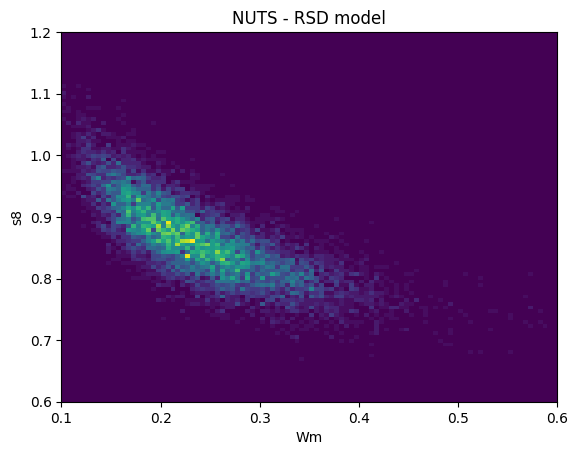

In [23]:
plt.hist2d(Wms_hmc, s8s_hmc, bins=100, range=[[0.1, 0.6],[0.6, 1.2]]);
plt.xlabel("Wm")
plt.ylabel("s8")
plt.title("NUTS - RSD model");